# UT2000 Beacon Summary
For the MADS framework paper, we need to present the data. This notebook looks at the data to make sure we have reasonable values at least in terms of the beacon.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import os.path
from os import path

from datetime import datetime, timedelta
import pytz

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import pandas as pd
import numpy as np

# ID Crossover
We need the IDs from the multiply modalities to cross-reference the participants.

In [3]:
ids_1000 = pd.read_csv('../data/raw/ut1000/admin/id_crossover.csv')
# limiting so we don't have repeats with ut2000
ids_1000 = ids_1000[ids_1000['record'] < 2000]
ids_1000.head()

,record,beiwe,beacon
0,1025,2qki3fim,NaN
1,1041,ygny19ey,NaN
2,1063,wozr2hv8,NaN
3,1065,11i3mr4n,NaN
4,1083,5buzzcr7,NaN


In [4]:
ids_2000 = pd.read_csv('../data/raw/ut2000/admin/id_crossover.csv')
ids_2000.head()

,record,beiwe,beacon
0,2000,wsv7bqh4,NaN
1,2001,vcdohuvw,NaN
2,2002,7zo5b6ma,NaN
3,2003,gy1mxy8v,NaN
4,2004,qbrarqn9,NaN


In [5]:
# combining ut1000 and 2000 records
ids = ids_1000.append(ids_2000)

# Beacon Data
The beacon data can be read in based on the beiwe IDs of the participants

## PM Data

In [87]:
pm_df = pd.DataFrame()
measurements = [
         'pm1.0',
         'pm2.5',
         'pm10',
         'std1.0',
         'std2.5',
         'std10',
         'pc0.3',
         'pc0.5',
         'pc1.0',
         'pc2.5',
         'pc5.0',
         'pc10.0'
   ]
for folder in os.listdir('../data/raw/ut2000/beacon/'):
    beacon_no = folder[-2:]
    if beacon_no in ['01','02','03','05','06','07','08','09','10','11','12','20']:
        beacon_df = pd.DataFrame()
        for file in os.listdir(f'../data/raw/ut2000/beacon/{folder}/bevo/pms5003/'):
            if file[-1] == 'v':
                temp = pd.read_csv(f'../data/raw/ut2000/beacon/{folder}/bevo/pms5003/{file}',names=measurements,
                                  parse_dates=True,infer_datetime_format=True)
                if len(temp) > 1:
                    beacon_df = pd.concat([beacon_df,temp])

        if len(beacon_df) > 0:
            beacon_df['number'] = beacon_no
            pm_df = pd.concat([pm_df,beacon_df])
            
dt = []
for i in range(len(pm_df)):
    if isinstance(pm_df.index[i], str):
        try:
            ts = int(pm_df.index[i])
        except ValueError:
            ts = int(pm_df.index[i][:-2])
        dt.append(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))
    else:
        dt.append(datetime.now())

pm_df['datetime'] = dt
pm_df['datetime'] = pd.to_datetime(pm_df['datetime'])
pm_df.set_index('datetime',inplace=True)

There seems to be issues with the data - the PM10 values should be the greatest while the PM1 values should be the smallest - they appear reversed. Also, no need to include the STD values since they really make no sense. 

In [88]:
pm_df = pm_df[['pm1.0','pm2.5','pm10','number']]
pm_df.columns = ['pm10','pm2.5','pm1','number']
pm_df

,pm10,pm2.5,pm1,number
datetime,,,,
2019-04-16 05:03:38,60.0000,16.8750,0.4375,06
2019-04-16 05:09:59,43.5000,13.2500,2.1250,06
2019-04-16 05:16:20,43.8750,13.8750,0.9375,06
2019-04-16 05:22:41,36.1875,11.1250,1.2500,06
2019-04-16 05:28:58,37.8750,12.6250,3.2500,06
...,...,...,...,...
2019-03-05 22:13:32,32.0625,8.7500,1.5625,20
2019-03-05 22:47:53,27.1875,8.0625,1.1875,20
2019-03-05 22:54:16,28.3125,7.9375,1.3125,20


In [89]:
np.nanmean(pm_df['pm10'])

134.4883215024974

### Visualizing to Get a Sense of the Concentrations

Beacons of concern:
- 1: Data seems unusable for the duration of the study
- 2: Data seems unusable for the duration of the study
- 3: Isolated incidents that can be removed
- 5: Isolated incidents that can be removed
- 6: Isolated incidents that can be removed

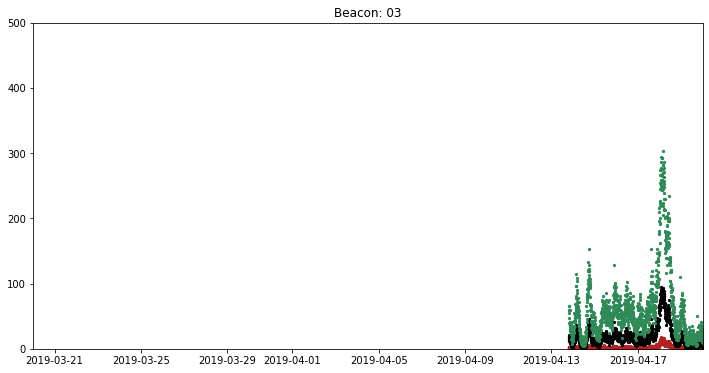

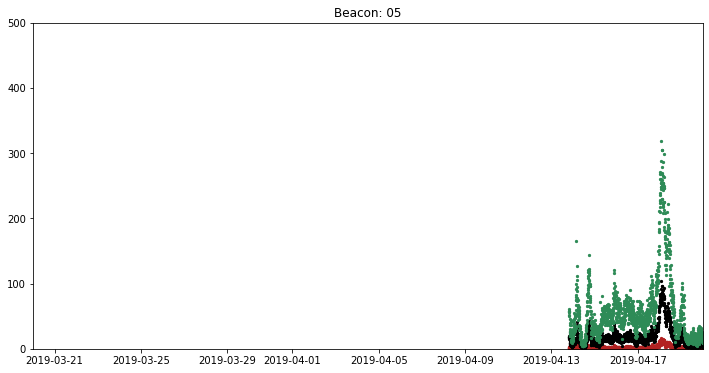

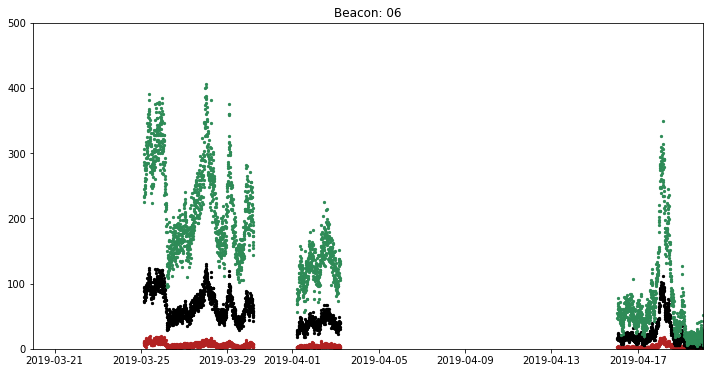

In [90]:
for beacon in ['03','05','06']:#pm_df['number'].unique():
    #beacon = '01'
    pm_pt = pm_df[pm_df['number'] == beacon]
    fig, ax = plt.subplots(figsize=(12,6))
    ax.scatter(pm_pt.index,pm_pt['pm1'],color='firebrick',s=5)
    ax.scatter(pm_pt.index,pm_pt['pm2.5'],color='black',s=5)
    ax.scatter(pm_pt.index,pm_pt['pm10'],color='seagreen',s=5)

    ax.set_title(f'Beacon: {beacon}')
    ax.set_xlim([datetime(2019,3,20),datetime(2019,4,20)])
    ax.set_ylim([0,500])

    plt.show()
    plt.close()